# 交通事故資料分析與預處理流程說明

---

## 1. 資料載入與初步探索（Data Loading & Basic Inspection）

### 功能
- 載入 CSV 檔案
- 顯示資料集基本資訊（資料量、欄位名稱）
- 檢查每欄資料型別
- 分析缺失值狀況

### 原理
- 使用 `pandas.read_csv()` 讀取資料
- 使用 `df.info()` 和 `df.describe()` 檢視統計摘要
- 使用 `df.isnull().sum()` 檢查缺失值分布

---

## 2. 資料清理與標準化（Data Cleaning & Normalization）

### 功能
- 時間欄位轉為 `datetime` 格式
- 擷取時間特徵（小時、週幾、月份等）
- 天氣條件欄位標準化
- 移除或修正數值型異常值

### 原理
- 使用 `pd.to_datetime()` 處理時間格式
- 使用 `.dt` 屬性擷取時間欄位細節
- 建立天氣條件轉換字典進行對應修正
- 使用 IQR 方法識別並修正異常值

---

## 3. 探索性資料分析（EDA: Exploratory Data Analysis）

### 功能
- 分析事故嚴重度 (`Severity`) 分布
- 時間模式探索（每日／每週趨勢）
- 天氣對事故的影響
- 數值特徵分布（如能見度、風速）
- 地理熱點與州別分布
- 道路類型與事故關聯分析

### 原理
- 使用 `value_counts()` 分析類別分布
- 使用 `groupby()` 進行統計聚合
- 使用 `pd.crosstab()` 交叉分析變數
- 使用箱型圖（boxplot）觀察極端值
- 使用熱力圖觀察特徵間的相關性

---

## 4. 特徵工程與選擇（Feature Engineering）

### 功能
- 類別特徵編碼（如 One-Hot 編碼）
- 建立交互特徵（例如：天氣 × 時段）
- 時間特徵轉換（如是否尖峰、週末等）
- 使用隨機森林進行特徵重要性分析
- 計算特徵間的相關係數矩陣
- 分析時間與天氣的組合關係
- 分析地點與天氣的組合關係
- 使用 SelectKBest 進行特徵選擇
- 建立新的時間特徵（尖峰時段、夜間、週末）
- 建立新的天氣特徵（惡劣天氣、良好能見度）
- 建立新的地點特徵（都市區域）

### 原理
- 使用 RandomForestClassifier 計算特徵重要性分數
- 使用 corr() 計算特徵相關係數
- 使用 crosstab() 分析特徵組合關係
- 使用 SelectKBest 和 f_classif 進行統計檢定
- 使用布林運算建立時間相關特徵
- 使用條件判斷建立天氣相關特徵
- 使用邏輯運算建立地點相關特徵



In [1]:
# %% [markdown]
# # 車禍資料分析與特徵工程

# %%
# 導入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import gc
from IPython.display import display, HTML

# 設定顯示選項
warnings.filterwarnings('ignore')
plt.ioff()  # 關閉互動模式
plt.style.use('default')  # 使用更簡單的樣式
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 設定圖表大小
plt.rcParams['figure.figsize'] = [6, 4]  # 減小默認圖表大小
plt.rcParams['figure.dpi'] = 100  # 降低圖表解析度

# %%
# 載入資料
print("正在載入資料...")
df = pd.read_csv("undersampled_2022.csv")

# %%
# 顯示基本資料資訊
print("\n=== 基本資料資訊 ===")
print(f"資料集大小: {df.shape}")



# %%
# 顯示數值型變量統計
print("\n=== 數值型變量統計 ===")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for i in range(0, len(numeric_cols), 5):
    chunk_cols = numeric_cols[i:i+5]
    display(df[chunk_cols].describe().style.background_gradient(cmap='YlOrRd'))
    gc.collect()

# %%
# 顯示缺失值統計
print("\n=== 缺失值統計 ===")
missing_stats = df.isnull().sum()
missing_df = pd.DataFrame({
    '缺失值數量': missing_stats,
    '缺失比例': (missing_stats / len(df) * 100).round(2)
})
display(missing_df[missing_df['缺失值數量'] > 0].style.background_gradient(cmap='YlOrRd'))






Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
正在載入資料...

=== 基本資料資訊 ===
資料集大小: (143520, 44)

=== 數值型變量統計 ===


,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F)
count,143520.000000,143520.000000,143520.000000,143520.000000,143520.000000
mean,2.500000,36.484823,-90.600340,0.590699,64.742712
std,1.118038,4.731206,15.572583,2.203922,19.233934
min,1.000000,24.589540,-124.466551,0.000000,-35.000000
25%,1.750000,33.692510,-97.175520,0.000000,54.000000
50%,2.500000,36.329437,-84.203328,0.019000,69.000000
75%,3.250000,40.120708,-79.553808,0.389000,79.000000
max,4.000000,48.974396,-68.283783,336.570007,162.000000


,Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
count,143520.000000,143520.000000,143520.000000,143520.000000,143520.000000
mean,63.622924,65.081557,29.263784,9.222322,7.207797
std,21.438462,22.759535,1.209655,2.236583,5.377700
min,-63.000000,2.000000,19.640000,0.000000,0.000000
25%,54.000000,48.000000,29.120000,10.000000,3.000000
50%,69.000000,67.000000,29.560000,10.000000,7.000000
75%,79.000000,84.000000,29.910000,10.000000,10.000000
max,162.000000,100.000000,58.390000,60.000000,132.000000


,Precipitation(in)
count,143520.000000
mean,0.005690
std,0.049147
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.190000



=== 缺失值統計 ===


,缺失值數量,缺失比例


## 2. 資料清理與標準化

In [2]:
# %% [markdown]
# ## 0. 資料載入與基礎清理
# （放在 Notebook 最前面，產生 df_clean）

import pandas as pd
from pathlib import Path



# -------- 0-1 日期轉型 --------
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time']   = pd.to_datetime(df['End_Time'],   errors='coerce')

# -------- 0-2 缺值補全 --------
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna('Unknown')

# -------- 0-3 IQR 切尾 --------
for c in num_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    df[c] = df[c].clip(lower=q1 - 1.5*iqr, upper=q3 + 1.5*iqr)

# -------- 0-4 存成 df_clean --------
df_clean = df
print(f"df_clean ready → shape = {df_clean.shape}")

df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'], format='mixed')
df_clean['End_Time'] = pd.to_datetime(df_clean['End_Time'], format='mixed')

# %% [markdown]
# ## 1. 時間衍生特徵與天氣標準化

print("衍生時間特徵...")
df_clean['Hour']       = df_clean['Start_Time'].dt.hour
df_clean['DayOfWeek']  = df_clean['Start_Time'].dt.dayofweek
df_clean['Month']      = df_clean['Start_Time'].dt.month
df_clean['IsWeekend']  = df_clean['DayOfWeek'].isin([5, 6]).astype(int)
df_clean['IsRushHour'] = df_clean['Hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
df_clean['IsNight']    = ((df_clean['Hour'] >= 22) | (df_clean['Hour'] <= 4)).astype(int)

print("標準化天氣條件...")
weather_conditions = {
    'Clear' : ['Clear', 'Fair', 'Sunny'],
    'Cloudy': ['Cloudy', 'Overcast', 'Partly Cloudy', 'Mostly Cloudy'],
    'Rain'  : ['Rain', 'Light Rain', 'Heavy Rain', 'Drizzle', 'Showers'],
    'Snow'  : ['Snow', 'Light Snow', 'Heavy Snow', 'Sleet', 'Hail'],
    'Fog'   : ['Fog', 'Mist', 'Haze', 'Smoke', 'Dust'],
    'Windy' : ['Windy', 'Breezy', 'Blustery'],
    'Other' : ['Other', 'Unknown']
}
def standardize_weather(cond):
    if pd.isna(cond):
        return 'Other'
    for k, v in weather_conditions.items():
        if cond in v:
            return k
    return 'Other'
df_clean['Weather_Category'] = df_clean['Weather_Condition'].apply(standardize_weather)

print("再次壓縮關鍵數值特徵 (IQR)...")
numeric_features = ['Temperature(F)', 'Wind_Speed(mph)', 'Visibility(mi)', 'Distance(mi)']
outliers_summary = []
for feat in numeric_features:
    if feat in df_clean.columns:
        q1, q3 = df_clean[feat].quantile([0.25, 0.75])
        iqr = q3 - q1
        mask = (df_clean[feat] < q1 - 1.5*iqr) | (df_clean[feat] > q3 + 1.5*iqr)
        outliers = mask.sum()
        df_clean[feat] = df_clean[feat].clip(lower=q1 - 1.5*iqr, upper=q3 + 1.5*iqr)
        outliers_summary.append({
            '特徵': feat,
            '異常值數量': outliers,
            '異常值比例': round(outliers / len(df_clean) * 100, 2)
        })

print("\n=== 異常值處理摘要 ===")
pd.DataFrame(outliers_summary)



df_clean ready → shape = (143520, 44)
衍生時間特徵...
標準化天氣條件...
再次壓縮關鍵數值特徵 (IQR)...

=== 異常值處理摘要 ===


,特徵,異常值數量,異常值比例
0,Temperature(F),0,0.000
1,Wind_Speed(mph),0,0.000
2,Visibility(mi),0,0.000
3,Distance(mi),0,0.000


## 3. 探索性資料分析 (EDA)


=== 1. 事故嚴重度分布 ===


,嚴重度,數量,比例
0,1,35880,25.000000
1,2,35880,25.000000
2,3,35880,25.000000
3,4,35880,25.000000


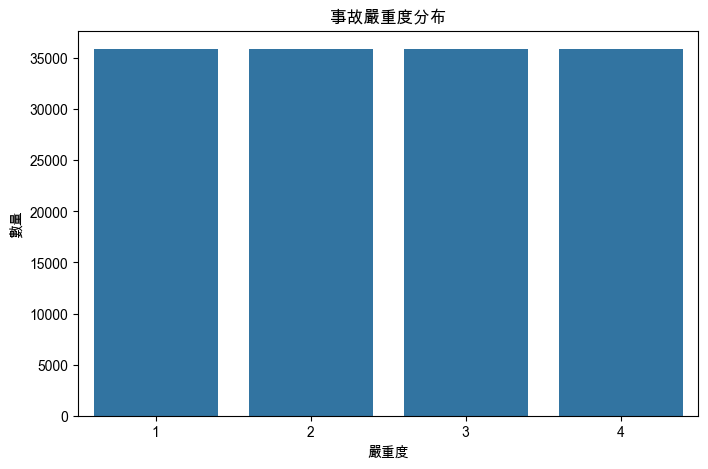


=== 2. 時間模式分析 ===

2.1 按小時分布


,事故數量,平均嚴重度
Hour,,
0,1872,3.260000
1,1469,3.200000
2,1691,2.990000
3,1598,2.960000
4,4472,2.090000
5,5310,2.200000
6,9113,2.070000
7,13873,1.950000
8,13719,1.930000


<Figure size 1000x500 with 0 Axes>

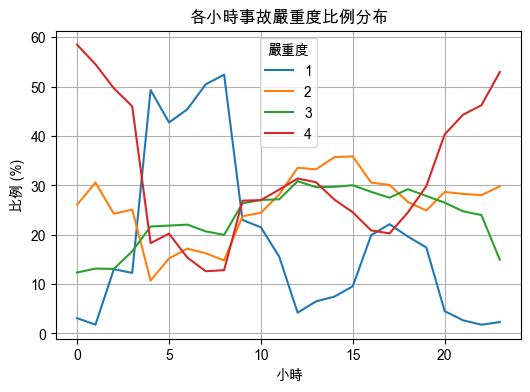


2.2 按星期分布


,事故數量,平均嚴重度
Weekday,,
週一,21995,2.410000
週三,25129,2.360000
週二,24248,2.370000
週五,24227,2.470000
週六,12263,3.040000
週四,25322,2.380000
週日,10336,3.070000


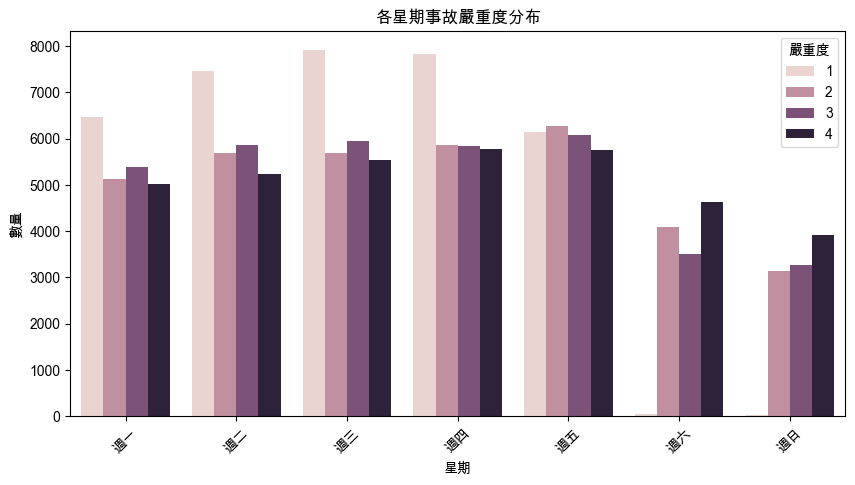


=== 3. 天氣影響分析 ===

3.1 天氣條件分布


,天氣條件,數量,比例
0,Clear,71908,50.100000
1,Cloudy,52739,36.750000
2,Rain,7305,5.090000
3,Other,6288,4.380000
4,Snow,2767,1.930000
5,Fog,2513,1.750000



3.2 天氣條件與事故嚴重度關係

各天氣條件下的事故數量：


Severity,1,2,3,4
Weather_Category,,,,
Clear,19316,17970,16322,18300
Cloudy,13835,12749,14004,12151
Fog,542,706,524,741
Other,1032,1706,1933,1617
Rain,1145,1866,2237,2057
Snow,10,883,860,1014



各天氣條件下的事故比例：


Severity,1,2,3,4
Weather_Category,,,,
Clear,26.862102,24.990265,22.698448,25.449185
Cloudy,26.232959,24.173761,26.553405,23.039876
Fog,21.567847,28.093912,20.851572,29.486669
Other,16.412214,27.131043,30.741094,25.715649
Rain,15.674196,25.544148,30.622861,28.158795
Snow,0.361402,31.911818,31.080593,36.646187


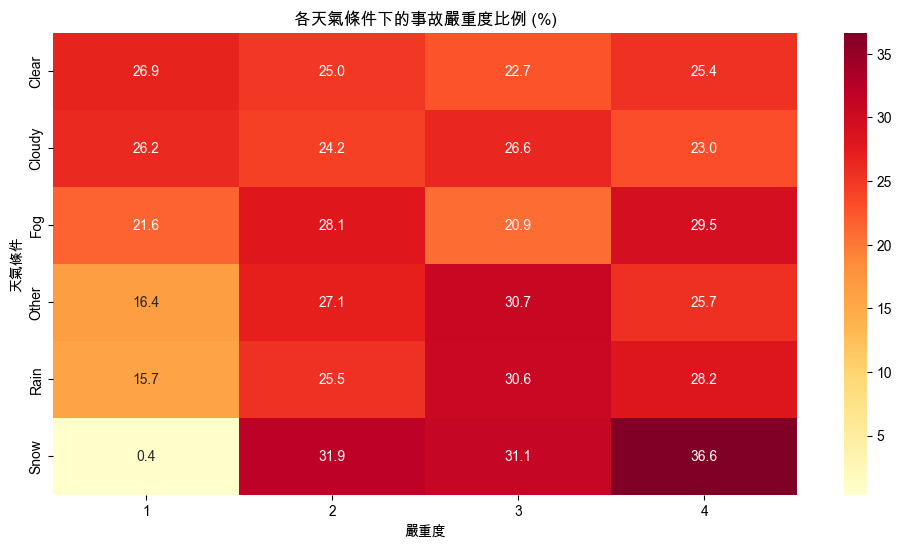


3.3 天氣條件與事故嚴重度的關係分析


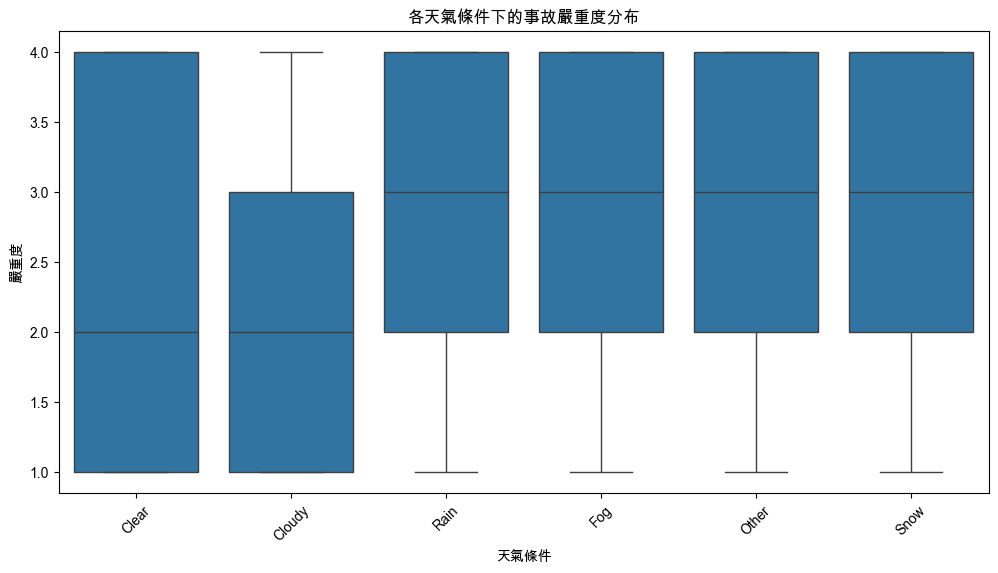


=== 4. 數值特徵分析 ===

4.1 數值特徵統計



4.2 數值特徵與嚴重度的關係


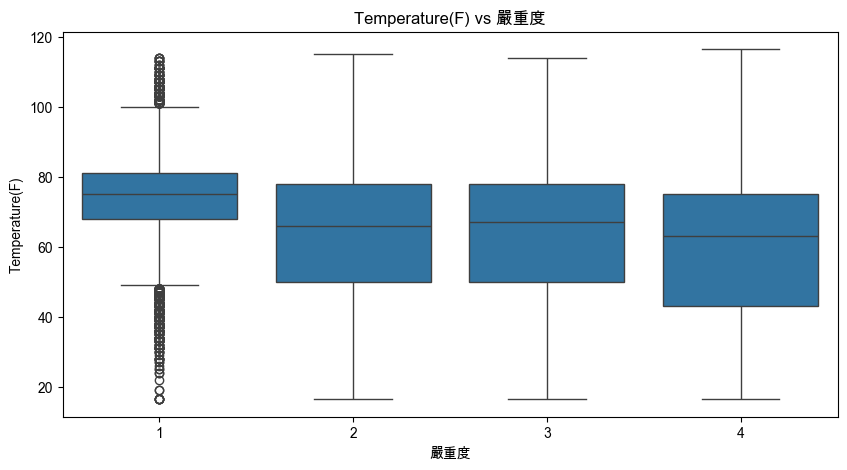

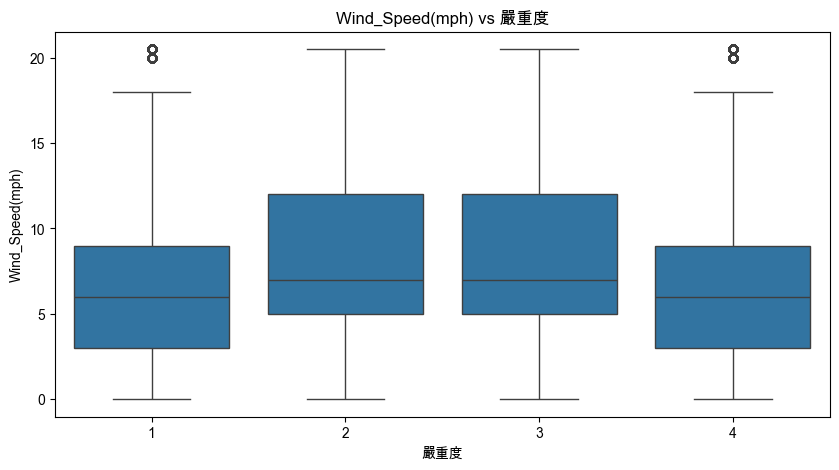

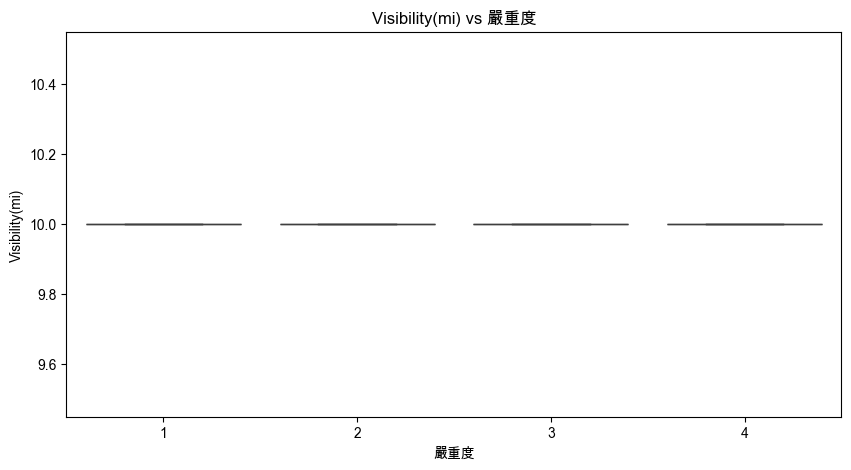

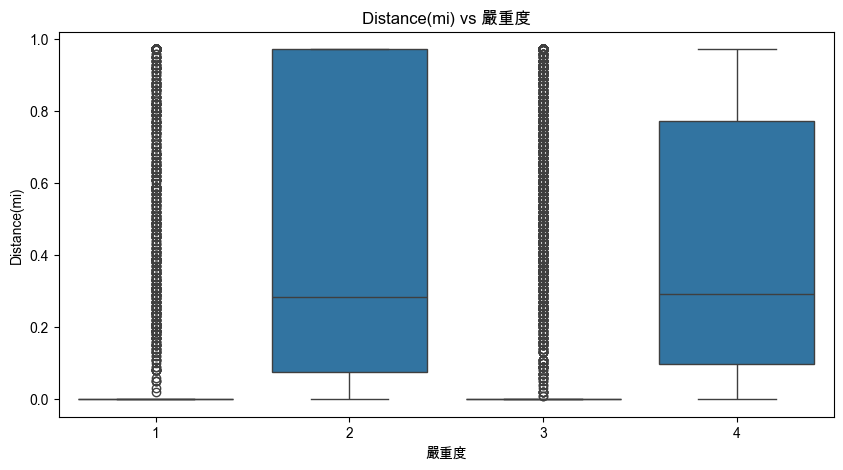


=== 5. 地理分布分析 ===


,州,事故數量,比例
0,CA,19624,13.670000
1,FL,13177,9.180000
2,TX,10257,7.150000
3,VA,10013,6.980000
4,SC,9245,6.440000
5,NC,8713,6.070000
6,PA,8139,5.670000
7,NY,5325,3.710000
8,GA,5108,3.560000
9,IL,4231,2.950000


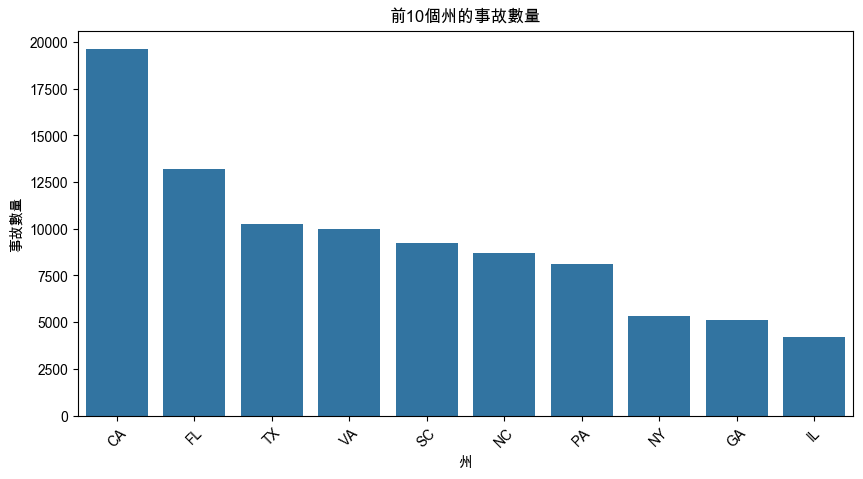


=== 6. 道路特徵分析 ===

6.1 道路特徵統計


,特徵,數量,比例
0,Traffic_Signal,20279,14.130000
1,Crossing,14393,10.030000
2,Junction,8358,5.820000
3,Stop,3992,2.780000
4,Station,3039,2.120000
5,Amenity,1565,1.090000
6,Railway,1197,0.830000
7,No_Exit,336,0.230000
8,Traffic_Calming,135,0.090000
9,Bump,51,0.040000



6.2 道路特徵與嚴重度的關係


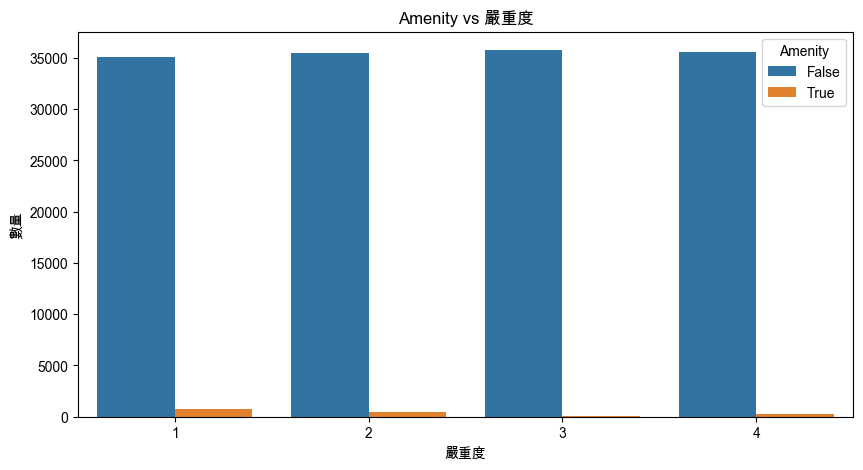

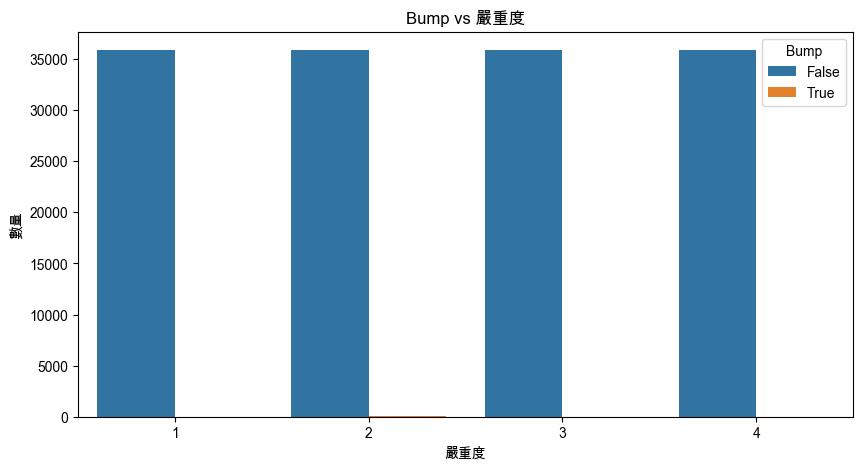

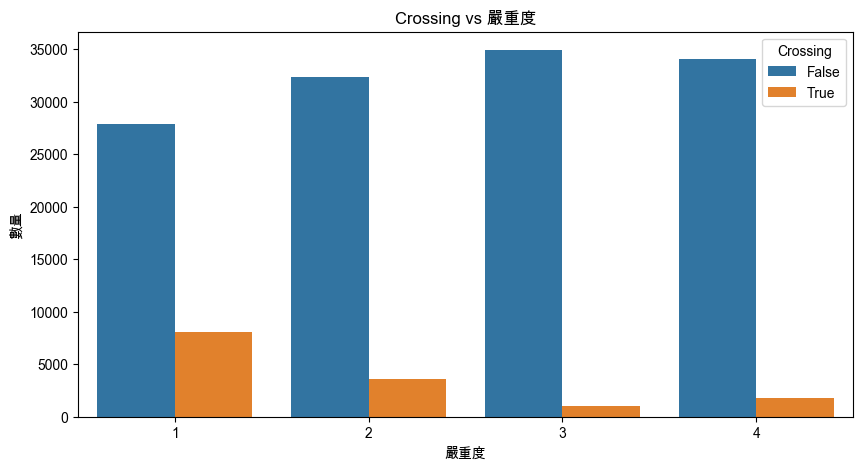

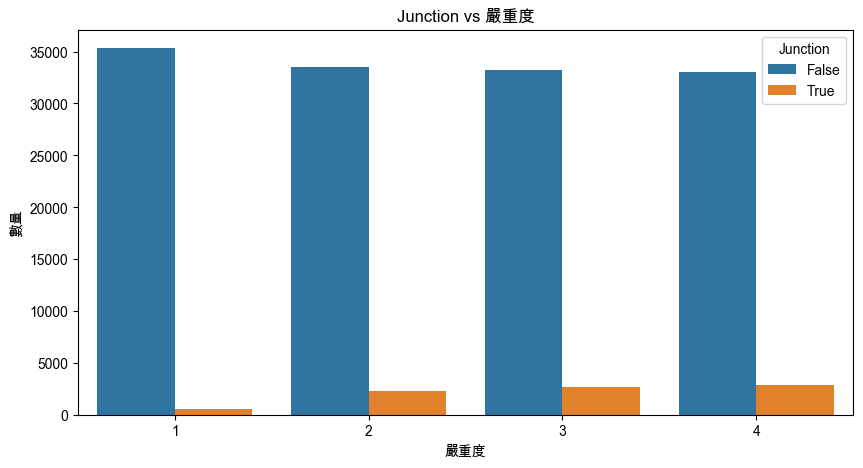

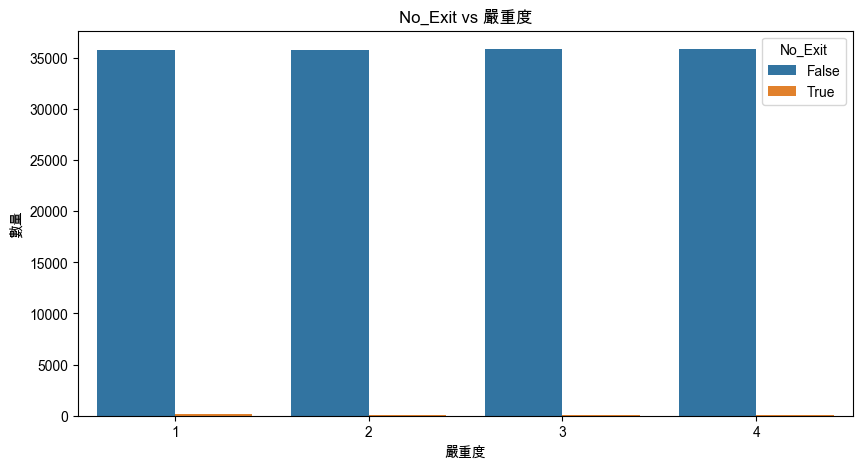

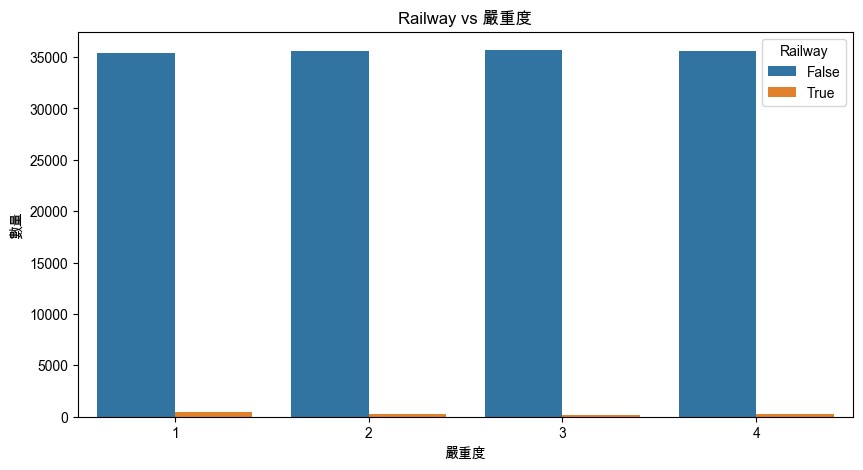

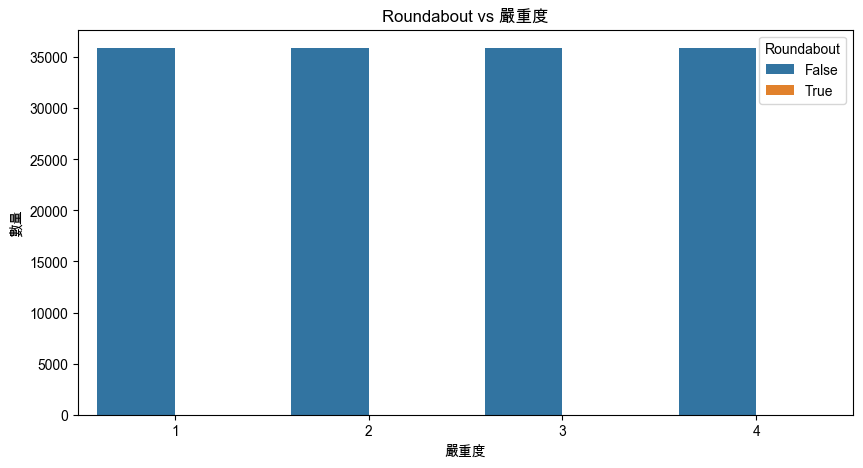

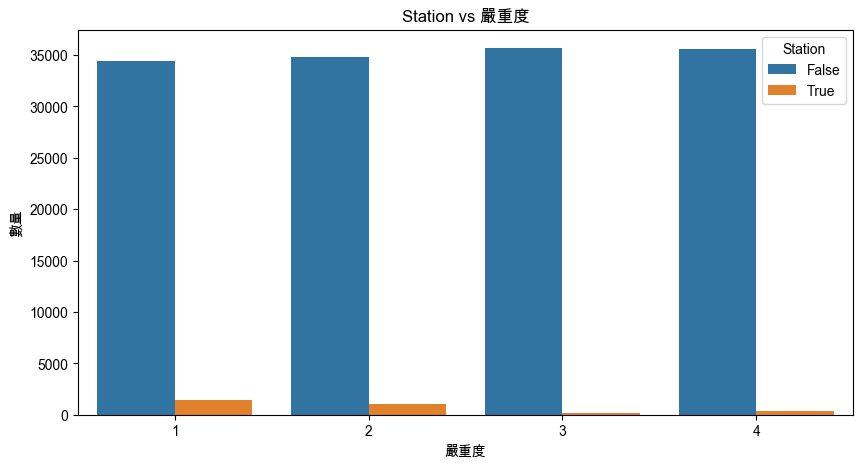

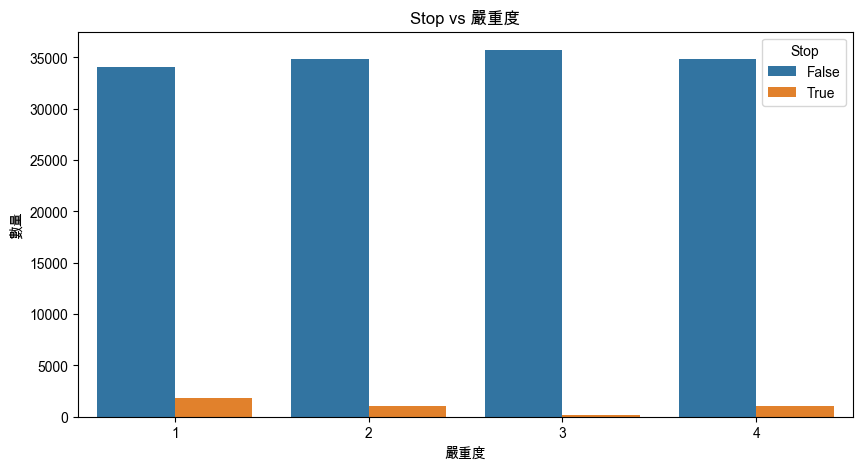

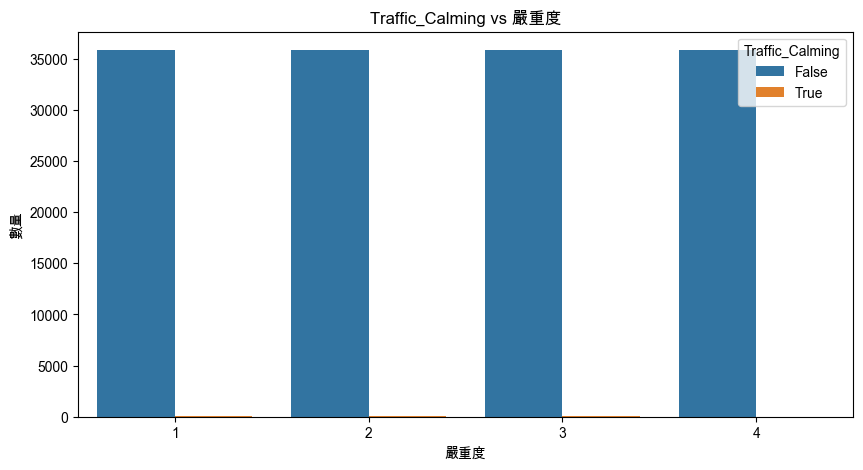

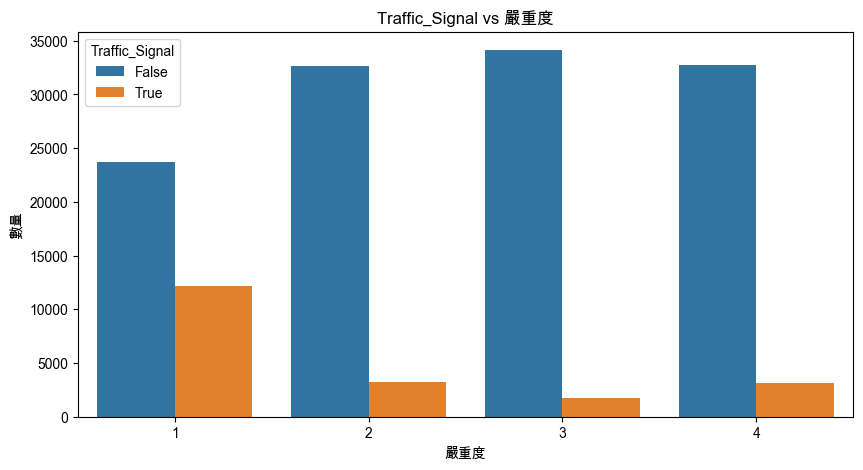

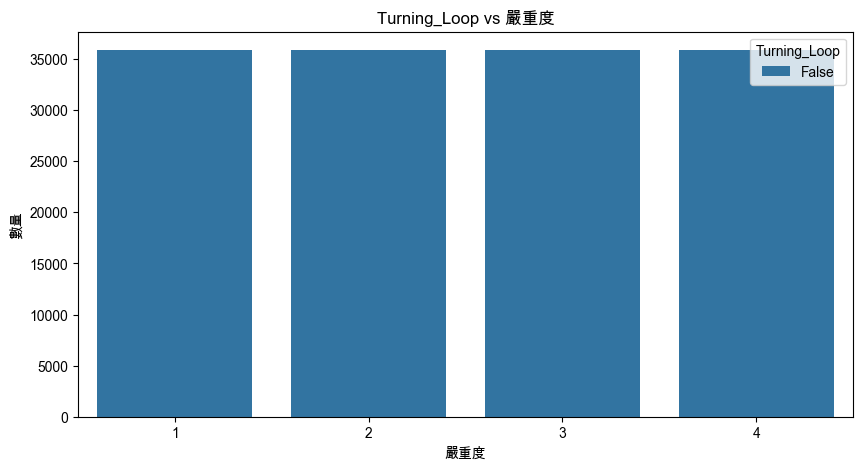

In [3]:
# %% [markdown]
# 
# 探索性資料分析幫助我們理解數據的特徵和模式

# %%
# 嚴重度分布分析
print("\n=== 1. 事故嚴重度分布 ===")
severity_counts = df_clean['Severity'].value_counts()
severity_df = pd.DataFrame({
    '嚴重度': severity_counts.index,
    '數量': severity_counts.values,
    '比例': (severity_counts.values / len(df_clean) * 100).round(2)
})
display(severity_df.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='Severity')
plt.title('事故嚴重度分布')
plt.xlabel('嚴重度')
plt.ylabel('數量')
plt.show()
plt.close()
gc.collect()

# %%
# 時間模式分析
print("\n=== 2. 時間模式分析 ===")

# 2.1 按小時分布
print("\n2.1 按小時分布")
hourly_stats = df_clean.groupby('Hour').agg({
    'Severity': ['count', 'mean']
}).round(2)
hourly_stats.columns = ['事故數量', '平均嚴重度']
display(hourly_stats.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(10, 5))
hourly_counts = df_clean.groupby(['Hour', 'Severity']).size().unstack()
hourly_counts_pct = hourly_counts.div(hourly_counts.sum(axis=1), axis=0) * 100
hourly_counts_pct.plot(kind='line')
plt.title('各小時事故嚴重度比例分布')
plt.xlabel('小時')
plt.ylabel('比例 (%)')
plt.legend(title='嚴重度')
plt.grid(True)
plt.show()
plt.close()
gc.collect()

# 2.2 按星期分布
print("\n2.2 按星期分布")
weekday_map = {0: '週一', 1: '週二', 2: '週三', 3: '週四', 4: '週五', 5: '週六', 6: '週日'}
df_clean['Weekday'] = df_clean['DayOfWeek'].map(weekday_map)

weekday_stats = df_clean.groupby('Weekday').agg({
    'Severity': ['count', 'mean']
}).round(2)
weekday_stats.columns = ['事故數量', '平均嚴重度']
display(weekday_stats.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='Weekday', hue='Severity', order=list(weekday_map.values()))
plt.title('各星期事故嚴重度分布')
plt.xlabel('星期')
plt.ylabel('數量')
plt.legend(title='嚴重度')
plt.xticks(rotation=45)
plt.show()
plt.close()
gc.collect()

# %%
# 天氣影響分析
print("\n=== 3. 天氣影響分析 ===")

# 3.1 天氣條件分布
print("\n3.1 天氣條件分布")
weather_counts = df_clean['Weather_Category'].value_counts()
weather_df = pd.DataFrame({
    '天氣條件': weather_counts.index,
    '數量': weather_counts.values,
    '比例': (weather_counts.values / len(df_clean) * 100).round(2)
})
display(weather_df.style.background_gradient(cmap='YlOrRd'))

# 3.2 天氣條件與事故嚴重度關係
print("\n3.2 天氣條件與事故嚴重度關係")
weather_severity = pd.crosstab(df_clean['Weather_Category'], df_clean['Severity'])
weather_severity_pct = weather_severity.div(weather_severity.sum(axis=1), axis=0) * 100

print("\n各天氣條件下的事故數量：")
display(weather_severity.style.background_gradient(cmap='YlOrRd'))

print("\n各天氣條件下的事故比例：")
display(weather_severity_pct.style.background_gradient(cmap='YlOrRd'))

# 繪製比例熱力圖
plt.figure(figsize=(12, 6))
sns.heatmap(weather_severity_pct, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('各天氣條件下的事故嚴重度比例 (%)')
plt.xlabel('嚴重度')
plt.ylabel('天氣條件')
plt.show()
plt.close()
gc.collect()

# 3.3 天氣條件與事故嚴重度的箱型圖
print("\n3.3 天氣條件與事故嚴重度的關係分析")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='Weather_Category', y='Severity')
plt.title('各天氣條件下的事故嚴重度分布')
plt.xlabel('天氣條件')
plt.ylabel('嚴重度')
plt.xticks(rotation=45)
plt.show()
plt.close()
gc.collect()

# %%
# 數值特徵分析
print("\n=== 4. 數值特徵分析 ===")
numeric_features = ['Temperature(F)', 'Wind_Speed(mph)', 'Visibility(mi)', 'Distance(mi)']

# 4.1 數值特徵統計
print("\n4.1 數值特徵統計")
numeric_stats = df_clean.groupby('Severity')[numeric_features].agg(['mean', 'std']).round(2)
display(numeric_stats.style.background_gradient(cmap='YlOrRd'))

# 4.2 數值特徵與嚴重度的關係
print("\n4.2 數值特徵與嚴重度的關係")
for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_clean, x='Severity', y=feature)
    plt.title(f'{feature} vs 嚴重度')
    plt.xlabel('嚴重度')
    plt.ylabel(feature)
    plt.show()
    plt.close()
    gc.collect()

# %%
# 地理分布分析
print("\n=== 5. 地理分布分析 ===")
state_stats = df_clean['State'].value_counts().head(10)
state_df = pd.DataFrame({
    '州': state_stats.index,
    '事故數量': state_stats.values,
    '比例': (state_stats.values / len(df_clean) * 100).round(2)
})
display(state_df.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(10, 5))
sns.barplot(x=state_stats.index, y=state_stats.values)
plt.title('前10個州的事故數量')
plt.xlabel('州')
plt.ylabel('事故數量')
plt.xticks(rotation=45)
plt.show()
plt.close()
gc.collect()

# %%
# 道路特徵分析
print("\n=== 6. 道路特徵分析 ===")
road_features = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 
                'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                'Traffic_Signal', 'Turning_Loop']

# 6.1 道路特徵統計
print("\n6.1 道路特徵統計")
road_feature_stats = df_clean[road_features].sum().sort_values(ascending=False)
road_df = pd.DataFrame({
    '特徵': road_feature_stats.index,
    '數量': road_feature_stats.values,
    '比例': (road_feature_stats.values / len(df_clean) * 100).round(2)
})
display(road_df.style.background_gradient(cmap='YlOrRd'))

# 6.2 道路特徵與嚴重度的關係
print("\n6.2 道路特徵與嚴重度的關係")
for feature in road_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_clean, x='Severity', hue=feature)
    plt.title(f'{feature} vs 嚴重度')
    plt.xlabel('嚴重度')
    plt.ylabel('數量')
    plt.legend(title=feature)
    plt.show()
    plt.close()
    gc.collect()

## 4. 特徵工程與選擇

In [15]:
pip install imbalanced-learn xgboost scikit-learn --upgrade


Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Note: you may need to restart the kernel to use updated packages.


In [4]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

RANDOM_STATE = 42
TEST_RATIO   = 0.20

# ----------------------------- 4-1. Feature Engineering -----------------------------
print("▶ 4-1. Feature Engineering...")

df_fe = df_clean.copy()

# 時間特徵
df_fe['IsRushHour']  = ((df_fe['Hour'].between(7, 9)) | (df_fe['Hour'].between(16, 18))).astype(int)
df_fe['IsNight']     = ((df_fe['Hour'] >= 22) | (df_fe['Hour'] <= 4)).astype(int)
df_fe['IsWeekend']   = df_fe['DayOfWeek'].isin([5, 6]).astype(int)

# 天氣特徵
df_fe['IsBadWeather']      = df_fe['Weather_Condition'].isin(['Rain', 'Snow', 'Fog']).astype(int)
df_fe['IsGoodVisibility']  = (df_fe['Visibility(mi)'] > 10).astype(int)

# 地點特徵
df_fe['IsUrban'] = (df_fe[['Amenity','Bump','Crossing','Junction']].any(axis=1)).astype(int)


# ----------------------------- 4-2. 欄位定義 -----------------------------
time_features     = ['Hour', 'DayOfWeek', 'Month', 'IsRushHour', 'IsNight', 'IsWeekend']
weather_features  = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                     'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
                     'IsBadWeather', 'IsGoodVisibility']
location_features = ['Start_Lat', 'Start_Lng', 'IsUrban']
road_features     = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway',
                     'Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal',
                     'Turning_Loop']

all_features = time_features + weather_features + location_features + road_features
target = 'Severity'



▶ 4-1. Feature Engineering...


In [ ]:
# ----------------------------- 4-3. Train / Test Split -----------------------------
X = df_fe[all_features]
y = df_fe[target]

# 在這裡利用 LabelEncoder 把 y 從 [1,2,3,4] → [0,1,2,3]
le = LabelEncoder()
y_enc = le.fit_transform(y)    # 例如：1→0, 2→1, 3→2, 4→3

X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_enc, test_size=TEST_RATIO, stratify=y_enc, random_state=RANDOM_STATE
)

# 如果後面想要檢視原始的 y_test：
# y_test_orig = le.inverse_transform(y_test_enc)

cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols = X_train.select_dtypes(exclude='object').columns.tolist()


# ----------------------------- 4-4. 共用前處理器 preprocess -----------------------------
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# 先 fit 一次 preprocess，才能拿到 OHE 後的欄位名稱 full_cols
preprocess.fit(X_train)
if cat_cols:
    ohe_cols   = preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols)
    full_cols  = num_cols + ohe_cols.tolist()
else:
    full_cols = num_cols.copy()


# ----------------------------- 4-5. XGBoost Training -----------------------------
print("\n▶ 4-5. XGBoost Classifier Training...")

xgb_clf = XGBClassifier(
    n_estimators=300,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)

pipe_xgb = Pipeline([
    ('prep', preprocess),
    ('model', xgb_clf)
])

# 這邊 fit 用的是 已編碼成 0-base 的 y_train_enc
pipe_xgb.fit(X_train, y_train_enc)
y_pred_enc = pipe_xgb.predict(X_test)

# 必要時，可以「反編碼回原始 label」再做 report：
y_pred_orig = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test_enc)

print("\n▶ XGBoost 評估（編碼前→後再反編碼）:")
print(classification_report(y_test_orig, y_pred_orig, digits=3))


# ----------------------------- 4-6. XGBoost 特徵重要性 -----------------------------
print("\n▶ 4-6. XGBoost Feature Importances...")

fi = pd.Series(
    pipe_xgb.named_steps['model'].feature_importances_,
    index=full_cols
).sort_values(ascending=False)

top20 = fi.head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=top20.values, y=top20.index, orient='h')
plt.title("Top-20 Feature Importances (XGBoost)")
plt.tight_layout(); plt.show(); plt.close()


# ----------------------------- 4-7. SelectKBest (ANOVA F) -----------------------------
print("\n▶ 4-7. SelectKBest (ANOVA F) 與 XGBoost 前處理器...")

pipe_kbest = Pipeline([
    ('prep', preprocess),
    ('kbest', SelectKBest(f_classif, k=20))
])

# 這裡 SelectKBest 也要給「編碼後的 y_train_enc」
pipe_kbest.fit(X_train, y_train_enc)
mask = pipe_kbest.named_steps['kbest'].get_support()
kbest_cols = np.array(full_cols)[mask]


# ----------------------------- 4-8. 數值特徵相關係數矩陣 -----------------------------
print("\n▶ 4-8. Correlation Matrix (Numeric Features)...")
plt.figure(figsize=(12,8))
sns.heatmap(df_fe[num_cols].corr(), cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout(); plt.show(); plt.close()


# ----------------------------- 4-9. 時段 × 天氣 Heatmap -----------------------------
print("\n▶ 4-9. Hour × Weather Heatmap...")
time_weather = pd.crosstab(df_fe['Hour'], df_fe['Weather_Condition'])
plt.figure(figsize=(10,6))
sns.heatmap(
    time_weather.div(time_weather.sum(axis=1), axis=0)*100,
    cmap='YlOrRd', fmt='.1f'
)
plt.title("Hourly Weather Distribution (%)")
plt.tight_layout(); plt.show(); plt.close()


# ----------------------------- 4-10. 州 × 天氣 Heatmap -----------------------------
print("\n▶ 4-10. State × Weather Heatmap...")
state_weather = pd.crosstab(df_fe['State'], df_fe['Weather_Condition'])
plt.figure(figsize=(10,8))
sns.heatmap(
    state_weather.div(state_weather.sum(axis=1), axis=0)*100,
    cmap='YlOrRd', fmt='.1f'
)
plt.title("State-wise Weather Distribution (%)")
plt.tight_layout(); plt.show(); plt.close()


# ----------------------------- 4-11. 最終特徵建議 -----------------------------
final_features = sorted(set(top20.index).union(kbest_cols))
print("\n▶ 綜合 XGBoost & SelectKBest，建議最終特徵共 {} 個：\n{}".format(
    len(final_features), final_features
))

# （可選）存檔
# pd.Series(final_features).to_csv("data/processed/final_feature_list.csv", index=False)
# print("✅ Final feature list已存檔")


# 特徵重要性分析說明

## 1. 時間特徵
### Month（月份）
- **定義**：事故發生的月份（1-12月）
- **重要性**：不同月份可能有不同的天氣條件和交通流量
- **應用**：例如：冬季可能更容易發生事故

### Hour（小時）
- **定義**：事故發生的具體時間（0-23時）
- **重要性**：反映交通流量和能見度的變化
- **應用**：例如：早晚高峰時段事故率較高

### DayOfWeek（星期幾）
- **定義**：事故發生的星期（0-6，0代表週一）
- **重要性**：反映工作日和週末的交通模式差異
- **應用**：例如：週末可能有不同的交通模式

## 2. 天氣特徵
### Pressure(in)（氣壓）
- **定義**：大氣壓力值（英寸）
- **重要性**：氣壓變化可能影響天氣狀況
- **應用**：例如：低氣壓通常伴隨惡劣天氣

### Humidity(%)（濕度）
- **定義**：空氣濕度百分比
- **重要性**：影響道路狀況和能見度
- **應用**：例如：高濕度可能導致路面濕滑

### Wind_Chill(F)（體感溫度）
- **定義**：考慮風速後的實際感受溫度（華氏度）
- **重要性**：影響駕駛條件和道路狀況
- **應用**：例如：低體感溫度可能導致路面結冰

### Temperature(F)（溫度）
- **定義**：實際溫度（華氏度）
- **重要性**：影響道路狀況和駕駛條件
- **應用**：例如：極端溫度可能影響車輛性能

## 3. 地點特徵
### Start_Lat（起始緯度）和 Start_Lng（起始經度）
- **定義**：事故發生的地理座標
- **重要性**：反映地理位置的影響
- **應用**：例如：不同地區可能有不同的交通規則和道路設計

## 4. 道路特徵
### Traffic_Signal（交通信號燈）
- **定義**：事故發生地點是否有交通信號燈
- **重要性**：反映交通控制設施的影響
- **應用**：例如：有信號燈的路口可能更容易發生追尾事故

### Crossing（交叉路口）
- **定義**：是否在交叉路口
- **重要性**：反映道路複雜度
- **應用**：例如：交叉路口是事故高發區域

### Junction（道路交匯處）
- **定義**：是否在道路交匯處
- **重要性**：反映交通流量和複雜度
- **應用**：例如：交匯處可能更容易發生側面碰撞

## 特徵重要性總結
1. **時間因素**（月份、小時、星期）對事故發生有重要影響
2. **天氣條件**（特別是氣壓、濕度和體感溫度）是關鍵因素
3. **地理位置**（經緯度）反映了不同地區的事故模式
4. **道路設施**（信號燈、交叉路口、交匯處）是事故發生的主要場所

## 應用價值
1. 預測事故高發時段和地點
2. 制定針對性的預防措施
3. 優化交通管理策略
4. 改善道路安全設施

## 5. 資料導出（會爆）

In [ ]:


# # %%
# # 保存結果
# print("開始保存結果...")
# df_feat.to_csv("features_ready.csv", index=False)

# print("\n=== 特徵工程報告 ===")
# print(f"1. 資料集大小: {df_feat.shape}")
# print("\n2. 特徵列表:")
# display(pd.DataFrame({
#     '特徵名稱': df_feat.columns,
#     '資料類型': df_feat.dtypes.values,
#     '非空值數量': df_feat.count().values
# }).style.background_gradient(cmap='YlOrRd'))

# print("\n3. 數值特徵統計:")
# display(df_feat.describe().style.background_gradient(cmap='YlOrRd'))

# print("\n4. 類別特徵統計:")
# categorical_cols = df_feat.select_dtypes(include=['object', 'category']).columns
# for col in categorical_cols:
#     print(f"\n{col} 的分布:")
#     display(pd.DataFrame({
#         '類別': df_feat[col].value_counts().index,
#         '數量': df_feat[col].value_counts().values,
#         '比例': (df_feat[col].value_counts().values / len(df_feat) * 100).round(2)
#     }).style.background_gradient(cmap='YlOrRd'))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

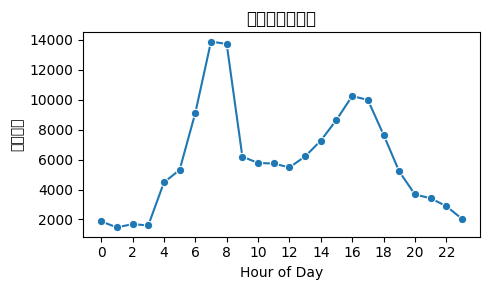

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

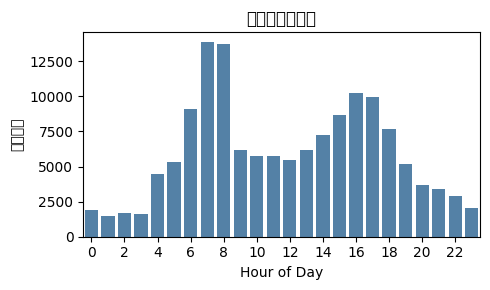

In [10]:
# 1.1 計算每個小時的事故筆數
hour_counts = df_clean['Hour'].value_counts().sort_index()

plt.figure(figsize=(5,3))
sns.lineplot(x=hour_counts.index, y=hour_counts.values, marker='o')
plt.xticks(range(0,24,2))  # 每兩個小時顯示一個刻度
plt.xlabel('Hour of Day')
plt.ylabel('事故筆數')
plt.title('每小時事故分布')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='steelblue')
plt.xticks(range(0,24,2))
plt.xlabel('Hour of Day')
plt.ylabel('事故筆數')
plt.title('每小時事故分布')
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 df_fe 已包含所有衍生欄位 (IsRushHour, IsBadWeather, Road_Complexity, Severity, …)
df_fe['Road_Complexity'] = df_fe[road_features].sum(axis=1)


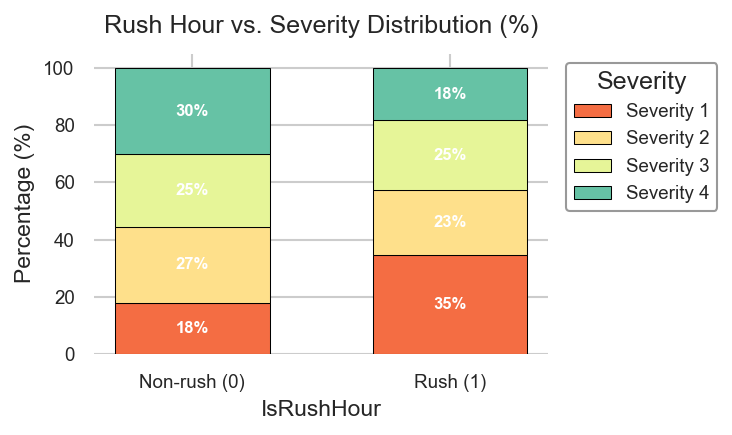

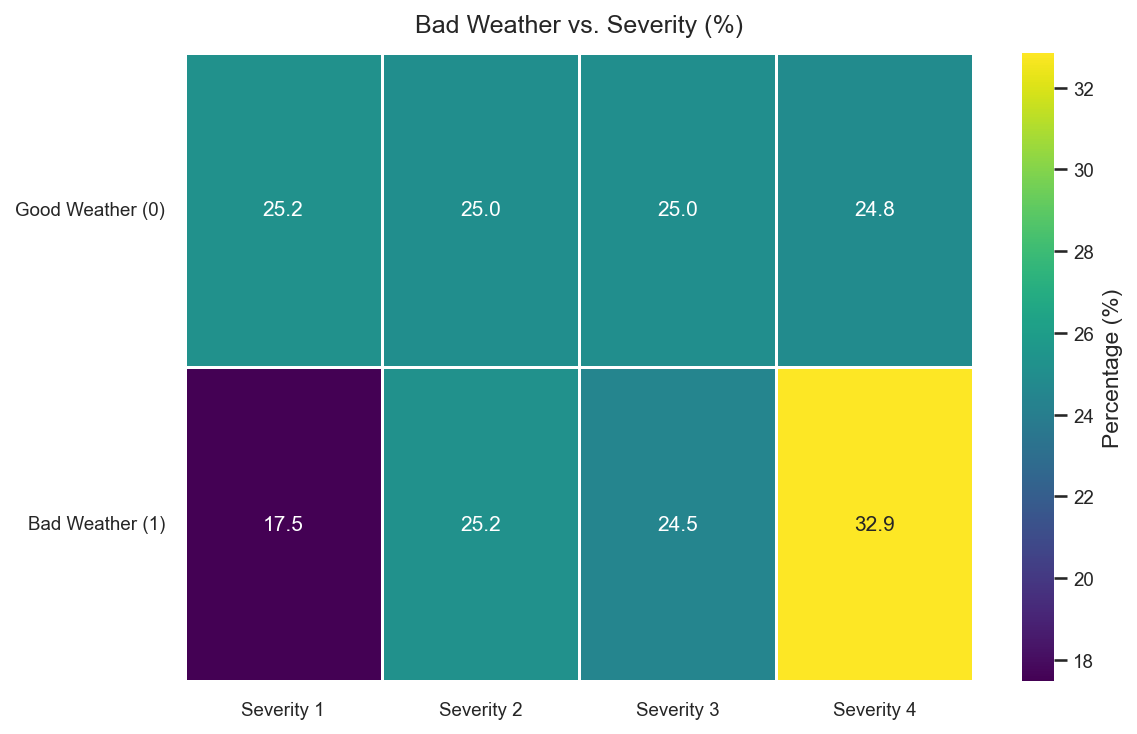

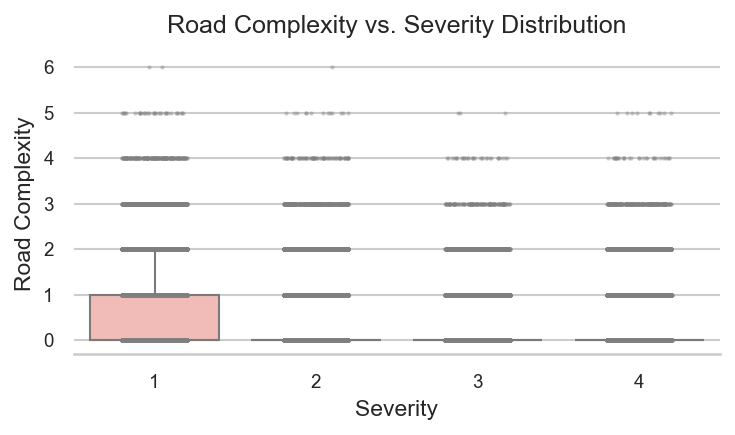

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_fe already contains all engineered columns (IsRushHour, IsBadWeather, Road_Complexity, Severity, etc.)
# If Road_Complexity hasn’t been computed yet, add:
df_fe['Road_Complexity'] = df_fe[road_features].sum(axis=1)

# -----------------------------------------------------------------------------
# Global styling: theme, font, sizes
# -----------------------------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'    # Use default sans-serif
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 150

# -----------------------------------------------------------------------------
# (1) Time feature: IsRushHour vs Severity — stacked bar chart
# -----------------------------------------------------------------------------
ct_time = pd.crosstab(df_fe['IsRushHour'], df_fe['Severity'])
ct_time_pct = ct_time.div(ct_time.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(5,3))

colors = sns.color_palette("Spectral", n_colors=ct_time_pct.shape[1])
bottom = None
for idx, col in enumerate(ct_time_pct.columns):
    values = ct_time_pct[col].values
    ax.bar(
        x=ct_time_pct.index,
        height=values,
        width=0.6,
        bottom=bottom,
        color=colors[idx],
        edgecolor='black',
        linewidth=0.5,
        label=f"Severity {col}"
    )
    bottom = values if bottom is None else bottom + values

# Add percentage annotations on each segment
for idx_x, xval in enumerate(ct_time_pct.index):
    cumulative = 0
    for idx_col, col in enumerate(ct_time_pct.columns):
        h = ct_time_pct[col].iloc[idx_x]
        if h > 0:
            ax.text(
                idx_x,
                cumulative + h / 2,
                f"{h:.0f}%",
                ha='center',
                va='center',
                color='white',
                fontsize=8,
                fontweight='bold'
            )
        cumulative += h

ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-rush (0)', 'Rush (1)'])
ax.set_xlabel('IsRushHour')
ax.set_ylabel('Percentage (%)')
ax.set_title('Rush Hour vs. Severity Distribution (%)', pad=10)
ax.legend(title='Severity', bbox_to_anchor=(1.02,1), loc='upper left', frameon=True, edgecolor='gray')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# (2) Weather feature: IsBadWeather vs Severity — heatmap
# -----------------------------------------------------------------------------
ct_weather = pd.crosstab(df_fe['IsBadWeather'], df_fe['Severity'])
ct_weather_pct = ct_weather.div(ct_weather.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(
    ct_weather_pct,
    cmap='viridis',
    annot=True,
    fmt='.1f',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Percentage (%)'},
    ax=ax
)

ax.set_xticklabels([f"Severity {i}" for i in ct_weather_pct.columns])
ax.set_yticklabels(['Good Weather (0)', 'Bad Weather (1)'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Bad Weather vs. Severity (%)', pad=10)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# (3) Geographic/Road feature: Road_Complexity vs Severity — boxplot + jittered points
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(
    x='Severity',
    y='Road_Complexity',
    data=df_fe,
    palette='Pastel1',
    showfliers=False,
    ax=ax
)
# Overlay jittered points to show actual distribution
sns.stripplot(
    x='Severity',
    y='Road_Complexity',
    data=df_fe,
    color='gray',
    size=2,
    jitter=0.2,
    alpha=0.4,
    ax=ax
)

ax.set_xlabel('Severity')
ax.set_ylabel('Road Complexity')
ax.set_title('Road Complexity vs. Severity Distribution', pad=10)

sns.despine(left=True)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

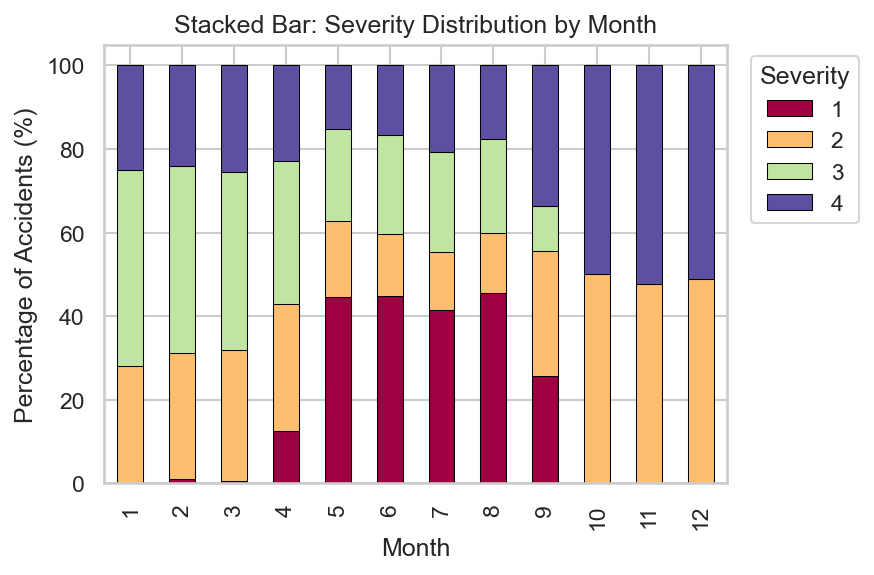

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 df_fe 已包含 'Month'（1–12）與 'Severity'（1–4）

# 1. 用 crosstab 計算「月份 × 嚴重度」的筆數
ct = pd.crosstab(df_fe['Month'], df_fe['Severity'])

# 2. 如果想看「比例」，就把每一列除以該列總和，再乘以 100
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# 3. 畫堆疊長條（顏色由 cmap 指定，下面用 Spectral 只是示範，你可以換其他）
plt.figure(figsize=(8, 4))
ct_pct.plot(
    kind='bar',
    stacked=True,
    colormap='Spectral',      # 這裡的「顏色」直接就對應到不同的 Severity
    edgecolor='black',
    linewidth=0.5
)

plt.xlabel('Month')  
plt.ylabel('Percentage of Accidents (%)')
plt.title('Stacked Bar: Severity Distribution by Month')
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
